In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import matplotlib.patches as mpatches

/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
ML_concat = pd.read_pickle('data/SS3_cast_UMIs_concat_ML.pkl')
ML_concat = ML_concat[ML_concat[1]][0]

cast_bs_UMI = pd.Series([gene[2]/gene[1] for gene in ML_concat], index=ML_concat.index)
cast_bf_UMI = pd.Series([gene[0] for gene in ML_concat], index=ML_concat.index)
cast_me_UMI = pd.Series([gene[2]*(gene[0]/(gene[1]+gene[0])) for gene in ML_concat], index=ML_concat.index)

gene_annotation = pd.read_csv('data/mouse_gene_annotation.csv', index_col=0)
gene_length = gene_annotation['txEnd'] - gene_annotation['txStart']
df = pd.DataFrame([np.log10(cast_bs_UMI), np.log10(gene_length), np.log10(cast_bf_UMI), np.log10(cast_me_UMI)], index=['bs','gl','bf', 'me']).T.dropna(how='any')
df.drop(gene_annotation['name2'][gene_annotation.chrom == 'chrX'].index.values, errors='ignore', inplace=True)

In [3]:
def bin_array(arr, l = 30):
    binned_arr  = np.array([])
    for i in range(np.int_(np.floor(len(arr)/l))-1):
        binned_arr = np.append(binned_arr, np.median(arr[l*i:l*(i+1)]))
    return binned_arr

In [4]:
INR = pd.read_csv('data/mouse_INR.bed', sep='\t', header=None)
TATA = pd.read_csv('data/mouse_TATA.bed', sep='\t', header=None)
names_TATA = [gene[3][:-2] for i,gene in TATA.iterrows()]
names_INR = [gene[3][:-2] for i,gene in INR.iterrows()]
TATA_index = df.loc[names_TATA].dropna(how='all').index
INR_index  = df.loc[names_INR].dropna(how='all').index
EPD_TATA = np.int_([name in TATA_index for name in df.index.values ])
EPD_INR = np.int_([name in INR_index for name in df.index.values ])
df['EPD_TATA'] = EPD_TATA
df['EPD_INR'] = EPD_INR
df['EPD_INR_and_TATA'] = EPD_TATA*EPD_INR

/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """
/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


In [5]:
df = df.sort_values(['EPD_TATA','EPD_INR'])
y,X = dmatrices('bs ~   gl*EPD_INR+gl*EPD_TATA +EPD_TATA*EPD_INR', data = df, return_type='dataframe')
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     bs   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     57.30
Date:                Wed, 19 Dec 2018   Prob (F-statistic):           1.87e-69
Time:                        18:55:47   Log-Likelihood:                -2909.9
No. Observations:                6935   AIC:                             5834.
Df Residuals:                    6928   BIC:                             5882.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.8650      0.045     19.397      0.000       0.778       0.952
gl                  -0.0751      0.010     -7.354      0.000      -0.095      -0.055
EPD_INR              0.0180      0.079      0.226      0.821      -0.138       0.174
gl:EPD_INR           0.0003      0.018      0.014      0.989      -0.035       0.035
EPD_TATA             0.6018      0.130      4.617      0.000       0.346       0.857
gl:EPD_TATA         -0.1006      0.031     -3.279      0.001      -0.161      -0.040
EPD_TATA:EPD_INR     0.1516      0.038      3.971      0.000       0.077       0.226
==============================================================================
Omnibus:                     1012.607   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1800.822
Skew:                           0.948   Prob(JB):                         0.00
Kurtosis:                       4.625   Cond. No.                         145.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
print('F test for gl = 0: ' + str(model.f_test('gl = 0')))
print('F test for EPD_TATA = 0: ' + str(model.f_test('EPD_TATA = 0')))
print('F test for gl:EPD_TATA = 0: ' + str(model.f_test('gl:EPD_TATA = 0')))
print('F test for EPD_INR = 0: ' + str(model.f_test('EPD_INR = 0')))
print('F test for EPD_TATA:EPD_INR = 0: ' + str(model.f_test('EPD_TATA:EPD_INR = 0')))

F test for gl = 0: <F test: F=array([[54.08198187]]), p=2.1441087450272985e-13, df_denom=6928, df_num=1>
F test for EPD_TATA = 0: <F test: F=array([[21.31262009]]), p=3.9718811899618714e-06, df_denom=6928, df_num=1>
F test for gl:EPD_TATA = 0: <F test: F=array([[10.7536088]]), p=0.0010458990982076118, df_denom=6928, df_num=1>
F test for EPD_INR = 0: <F test: F=array([[0.05115591]]), p=0.8210706416674722, df_denom=6928, df_num=1>
F test for EPD_TATA:EPD_INR = 0: <F test: F=array([[15.76539774]]), p=7.242752021215283e-05, df_denom=6928, df_num=1>


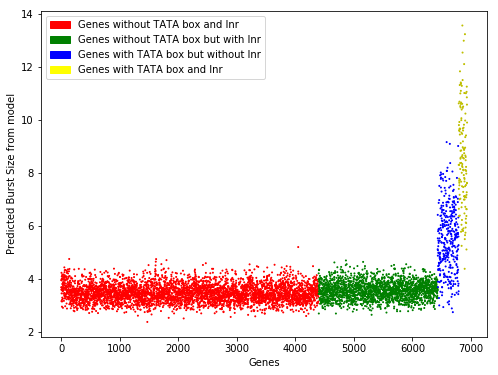

In [7]:

fig, ax = plt.subplots(figsize=(8,6))
red_patch = mpatches.Patch(color='red', label='Genes without TATA box and Inr')
green_patch = mpatches.Patch(color='green', label='Genes without TATA box but with Inr')
blue_patch = mpatches.Patch(color='blue', label='Genes with TATA box but without Inr')
yellow_patch = mpatches.Patch(color='yellow', label='Genes with TATA box and Inr')
ax.scatter(np.arange(len(df['gl'])), 10**np.array(model.fittedvalues), c = np.array(['r' if TATA == 0 and INI == 0 else 'b' if TATA == 1 and INI == 0 else 'green' if TATA == 0 and INI == 1 else 'y' for TATA, INI in zip(df['EPD_TATA'], df['EPD_INR'])]), s=1)#, alpha = 0.5)
plt.xlabel('Genes')
plt.ylabel('Predicted Burst Size from model')
legend = ax.legend(loc="best", handles=[red_patch, green_patch, blue_patch, yellow_patch])
plt.savefig('figures/Fig2b.pdf', dpi=100)
plt.show()

In [8]:
df['group'] = ''
df.loc[df[df['EPD_INR_and_TATA'] == 1].index, 'group']= 'TATA and Inr'
df.loc[df[(df['EPD_TATA'] == 1)&(df['EPD_INR'] == 0)].index,'group'] = 'TATA and no Inr'
df.loc[df[(df['EPD_TATA'] == 0)&(df['EPD_INR'] == 1)].index,'group'] = 'Inr and no TATA'
df.loc[df[(df['EPD_TATA'] == 0)&(df['EPD_INR'] == 0)].index,'group'] = 'No Inr and no TATA'


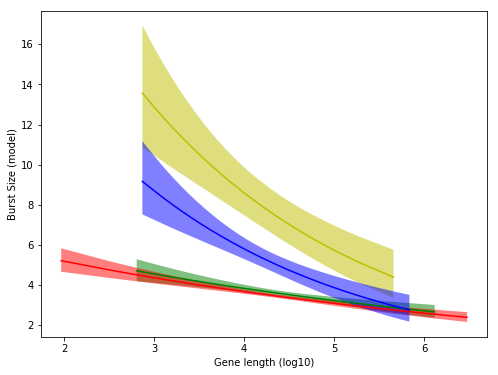

In [9]:
df = df.sort_values(['gl','EPD_TATA','EPD_INR'])
df_pred = model.get_prediction().summary_frame()
fill_color_dict = {}
mean_color_dict = {}
g_fillcolors = ['r', 'green', 'b', 'y']
for g_name,c_fill in zip(df['group'].unique(), g_fillcolors):
    fill_color_dict[g_name] = c_fill
    mean_color_dict[g_name] = c_fill
fig, ax = plt.subplots(figsize=(8,6))
red_patch = mpatches.Patch(color='red', label='Genes without TATA box and Inr')
green_patch = mpatches.Patch(color='green', label='Genes without TATA box but with Inr')
blue_patch = mpatches.Patch(color='blue', label='Genes with TATA box but without Inr')
yellow_patch = mpatches.Patch(color='yellow', label='Genes with TATA box and Inr')
for g in df.join(df_pred).groupby('group'):
    ax.plot(g[1]['gl'],10**g[1]['mean'], mean_color_dict[g[0]])
    ax.fill_between(g[1]['gl'],10**g[1]['mean_ci_lower'],10**g[1]['mean_ci_upper'],alpha=0.5, facecolor = fill_color_dict[g[0]])
plt.xlabel('Gene length (log10)')
plt.ylabel('Burst Size (model)')
plt.savefig('figures/Fig2c.pdf')
plt.show()

In [10]:
df = df.sort_values(['EPD_TATA','EPD_INR'])
y,X = dmatrices('me ~   gl*EPD_INR+gl*EPD_TATA +EPD_TATA*EPD_INR', data = df, return_type='dataframe')
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     me   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     16.16
Date:                Wed, 19 Dec 2018   Prob (F-statistic):           1.47e-18
Time:                        18:55:51   Log-Likelihood:                -6209.3
No. Observations:                6935   AIC:                         1.243e+04
Df Residuals:                    6928   BIC:                         1.248e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.5024      0.072      7.000      0.000       0.362       0.643
gl                  -0.1072      0.016     -6.524      0.000      -0.139      -0.075
EPD_INR              0.0910      0.128      0.712      0.476      -0.159       0.342
gl:EPD_INR          -0.0146      0.029     -0.506      0.613      -0.071       0.042
EPD_TATA             0.3674      0.210      1.752      0.080      -0.044       0.779
gl:EPD_TATA         -0.0763      0.049     -1.544      0.123      -0.173       0.021
EPD_TATA:EPD_INR     0.0588      0.061      0.957      0.339      -0.062       0.179
==============================================================================
Omnibus:                       66.899   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.809
Skew:                          -0.212   Prob(JB):                     2.55e-16
Kurtosis:                       3.263   Cond. No.                         145.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

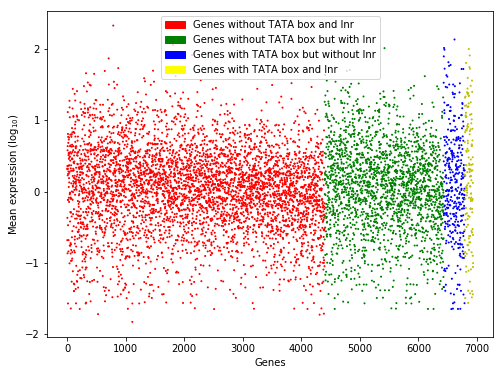

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
red_patch = mpatches.Patch(color='red', label='Genes without TATA box and Inr')
green_patch = mpatches.Patch(color='green', label='Genes without TATA box but with Inr')
blue_patch = mpatches.Patch(color='blue', label='Genes with TATA box but without Inr')
yellow_patch = mpatches.Patch(color='yellow', label='Genes with TATA box and Inr')
ax.scatter(np.arange(len(df['gl'])), df['me'], c = np.array(['r' if TATA == 0 and INI == 0 else 'b' if TATA == 1 and INI == 0 else 'green' if TATA == 0 and INI == 1 else 'y' for TATA, INI in zip(df['EPD_TATA'], df['EPD_INR'])]), s=1)#, alpha = 0.5)
plt.xlabel('Genes')
plt.ylabel('Mean expression (log$_{10}$)')
legend = ax.legend(loc="best", handles=[red_patch, green_patch, blue_patch, yellow_patch])
plt.savefig('figures/ExtDataFig3d.pdf')
plt.show()

In [12]:
y,X = dmatrices('bf ~   gl*EPD_INR+gl*EPD_TATA +EPD_TATA*EPD_INR', data = df, return_type='dataframe')
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     bf   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     9.308
Date:                Wed, 19 Dec 2018   Prob (F-statistic):           3.45e-10
Time:                        18:55:54   Log-Likelihood:                -5486.1
No. Observations:                6935   AIC:                         1.099e+04
Df Residuals:                    6928   BIC:                         1.103e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3045      0.065     -4.709      0.000      -0.431      -0.178
gl                  -0.0365      0.015     -2.463      0.014      -0.066      -0.007
EPD_INR              0.0689      0.115      0.599      0.549      -0.157       0.295
gl:EPD_INR          -0.0148      0.026     -0.567      0.571      -0.066       0.036
EPD_TATA            -0.2386      0.189     -1.262      0.207      -0.609       0.132
gl:EPD_TATA          0.0233      0.044      0.524      0.601      -0.064       0.111
EPD_TATA:EPD_INR    -0.0952      0.055     -1.720      0.085      -0.204       0.013
==============================================================================
Omnibus:                     1116.572   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1864.665
Skew:                          -1.072   Prob(JB):                         0.00
Kurtosis:                       4.363   Cond. No.                         145.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

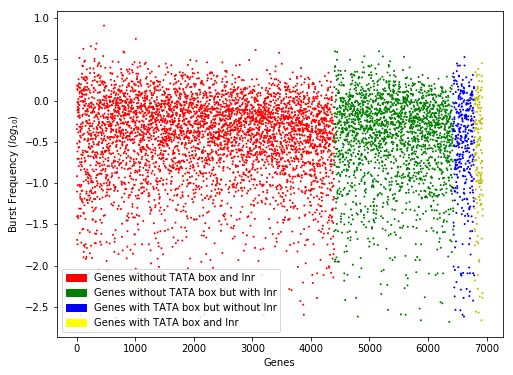

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
red_patch = mpatches.Patch(color='red', label='Genes without TATA box and Inr')
green_patch = mpatches.Patch(color='green', label='Genes without TATA box but with Inr')
blue_patch = mpatches.Patch(color='blue', label='Genes with TATA box but without Inr')
yellow_patch = mpatches.Patch(color='yellow', label='Genes with TATA box and Inr')
ax.scatter(np.arange(len(df['gl'])), df['bf'], c = np.array(['r' if TATA == 0 and INI == 0 else 'b' if TATA == 1 and INI == 0 else 'green' if TATA == 0 and INI == 1 else 'y' for TATA, INI in zip(df['EPD_TATA'], df['EPD_INR'])]), s=1)#, alpha = 0.5)
plt.xlabel('Genes')
plt.ylabel('Burst Frequency ($log_{10}$)')
legend = ax.legend(loc="best", handles=[red_patch, green_patch, blue_patch, yellow_patch])
plt.savefig('figures/ExtDataFig3e.pdf')
plt.show()

In [14]:
grouped = df.groupby('group')
cut_series=pd.cut(df.sort_values('gl')['gl'], bins=6)
cut_series.name = 'cut'
df['bs_notlog'] = 10**df['bs']
df = df.join(cut_series)


Inr and no TATA: n = 2035 genes (942, 531, 442, 74, 46 in each quintile respectively), No Inr and no TATA: n = 4397 genes (2585, 1124, 635, 36, 17 in each quintile respectively), TATA and Inr: n = 144 genes (53, 45, 24, 19, 3 in each quintile respectively), TATA and no Inr: n = 359 genes (129, 126, 58, 31, 15 in each quintile respectively), 

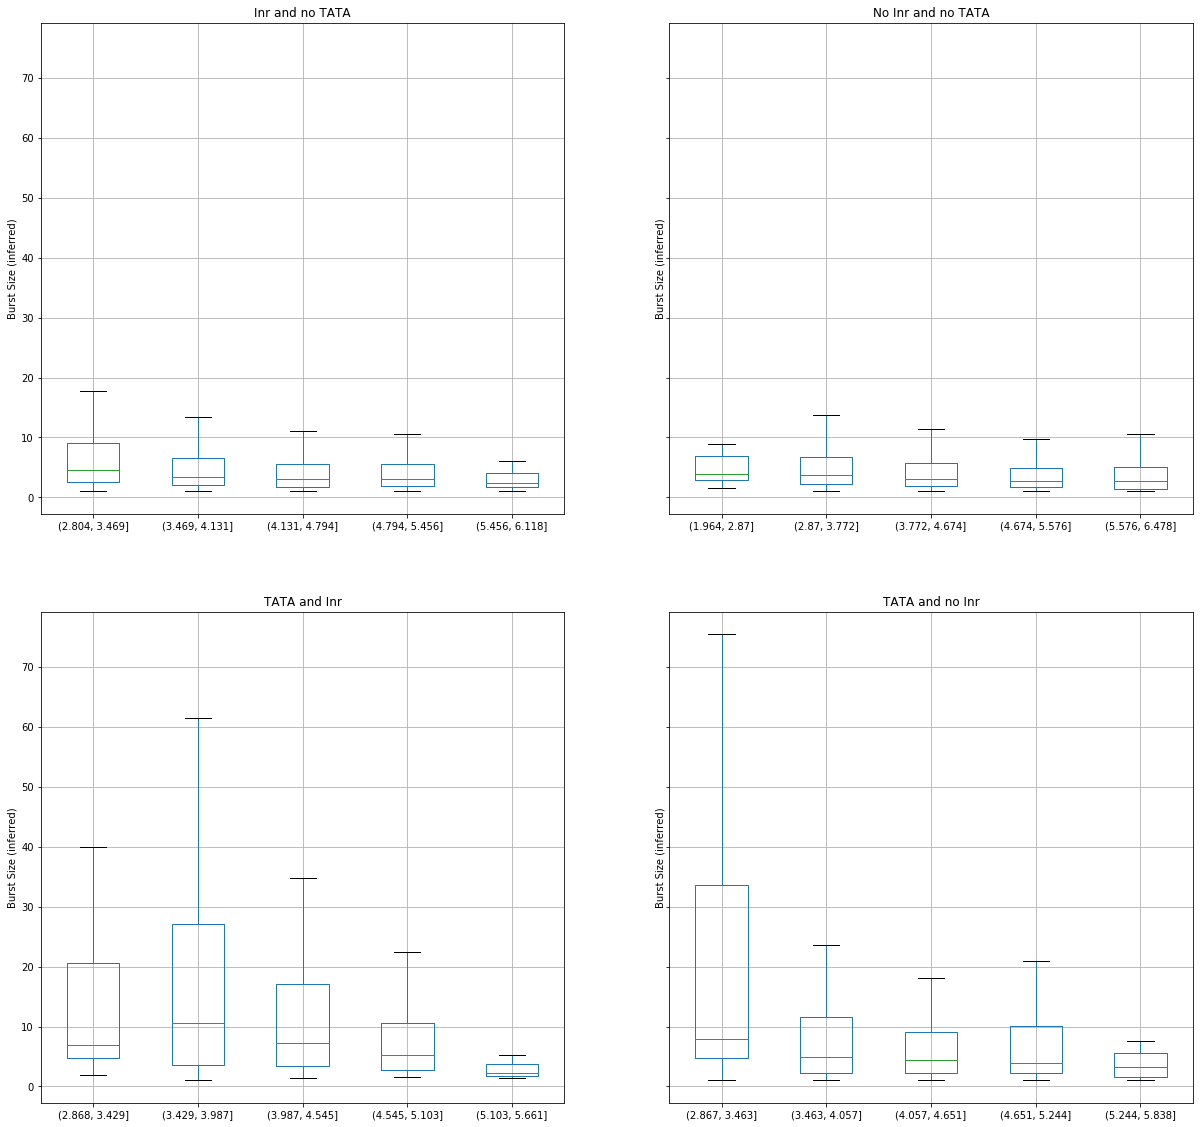

In [15]:
fig, subplots = plt.subplots(2,2, figsize = (20,20), sharey=True)
subplots = subplots.flatten()
for (name, group), ax in zip(grouped, subplots.flatten()):
    cut = pd.cut(group['gl'], bins=5)
    print('{}: n = {} genes ({}, {}, {}, {}, {} in each quintile respectively)'.format(name, cut.size, *cut.value_counts()), end=', ')
    group.boxplot(column='bs_notlog', by=cut.values, showfliers=False, ax=ax)
    #ax.set_suptitle('')
    ax.set_xlabel('')
    ax.set_title(name)
    ax.set_ylabel('Burst Size (inferred)')
plt.suptitle('')
plt.savefig('figures/ExtDataFig3g.pdf')
plt.show()

SpearmanrResult(correlation=-0.46167635288576997, pvalue=1.5255937336569122e-13)


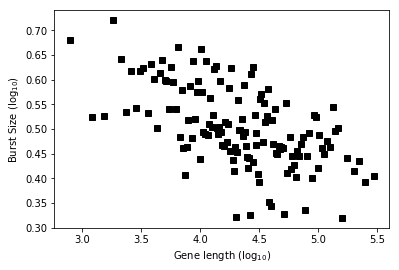

In [16]:
from scipy.stats import spearmanr
df = df.sort_values('gl')
l = 50
plt.plot(bin_array(df['gl'], l = l), bin_array(df['bs'], l = l), 's', c='black')
plt.ylabel('Burst Size (log$_{10}$)')
plt.xlabel(r'Gene length (log$_{10}$)')
print(spearmanr(bin_array(df['gl']), bin_array(df['bs'])))
plt.savefig('figures/ExtDataFig3a.pdf')
plt.show()

SpearmanrResult(correlation=-0.10276849552896372, pvalue=0.2320792746547986)


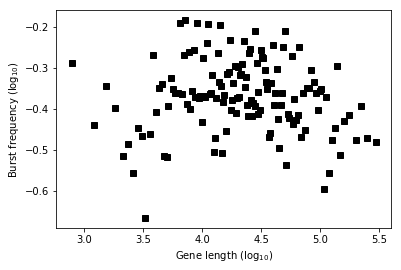

In [17]:
from scipy.stats import spearmanr
l = 50
plt.plot(bin_array(df['gl'], l = l), bin_array(df['bf'], l = l), 's', c='black')
plt.ylabel('Burst frequency (log$_{10}$)')
plt.xlabel(r'Gene length (log$_{10}$)')
print(spearmanr(bin_array(df['gl'],l=l), bin_array(df['bf'],l=l)))
plt.savefig('figures/ExtDataFig3b.pdf')
plt.show()

In [18]:
def toArray(gene):
    return np.array(np.int_(str(gene).split(',')[:-1]))

In [19]:
exon_length = pd.Series([np.sum(end-start) for start,end in zip(gene_annotation['exonStarts'].apply(toArray),gene_annotation['exonEnds'].apply(toArray))], index=gene_annotation.index)
gene_length = gene_annotation['txEnd'] - gene_annotation['txStart']

In [20]:
c57_UMI = pd.read_pickle('data/SS3_c57_UMIs_ML.pkl')
c57_UMI = c57_UMI[c57_UMI[1]][0]
c57_UMI = c57_UMI[~c57_UMI.index.duplicated(keep='first')]
c57_bs = pd.Series([gene[2]/gene[1] for gene in c57_UMI], index=c57_UMI.index)

df2 = pd.DataFrame([c57_bs, exon_length, gene_length], index=['bs', 'el', 'gl']).T.dropna(how='any')

In [21]:
def check_ranking(arr1,arr2,bs, l = 20):
    mat = np.zeros((np.int_(np.floor(len(arr1)/l))-1, l))
    for i in range(np.int_(np.floor(len(arr1)/l))-1):
        median = np.median(bs[l*i:l*(i+1)])
        ratio = arr2[l*i:l*(i+1)]
        mat[i,:] = (np.array(bs[l*i:l*(i+1)]-median)[np.argsort(ratio)])
    return mat

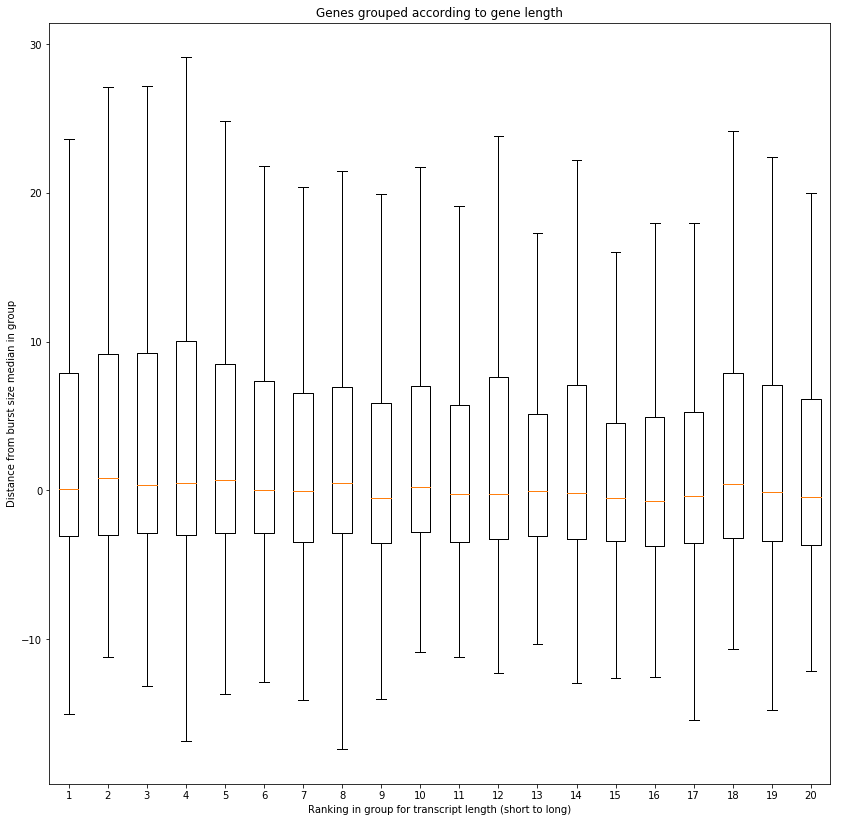

In [22]:
df2 = df2.sort_values('gl')
plt.figure(figsize=(14,14))
plt.boxplot(check_ranking(df2['gl'],df2['el'], df2['bs']), showfliers=False)
plt.title('Genes grouped according to gene length')
plt.ylabel('Distance from burst size median in group')
plt.xlabel('Ranking in group for transcript length (short to long)')
plt.savefig('figures/ExtDataFig3c.pdf')
plt.show()